0. Package Installation

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import time
import re

In [2]:
from utils.imageloader import load_images
from utils.save_image import save_image
from utils.dataloader import load_data
from utils.normalize import batch_normalize
from utils.gram_matrix import gram_matrix
from model.VGG16 import VGG16
from model.TransformerNet import TransformerNet

1. Hyperparameter Setting

In [3]:
batch_size = 8
num_epoch = 10
learning_rate = 1e-4
content_weight = 1e5
style_weight = 1e10
log_interval = 50
ckpt_dir = './checkpoints'
season1 = 'summer'
season2 = 'fall'
method = 'shake_feature' # 'one_season', 'shake_data', 'shake_feature'

2. Style Images and Train Data Loading

In [4]:
if(method == 'one_season' and season1 == season2):
    season = season1
    style_data = load_images('./data/', season)
elif(method == 'shake_data' and season1 != season2):
    season = season1 + '_' + season2 + '_data'
    style_data1 = load_images('./data/', season1)
    style_data2 = load_images('./data/', season2)
    idx1 = np.random.choice(10, 5)
    idx2 = np.random.choice(10, 5)
    style_data = torch.stack([style_data1[i] for i in idx1] + [style_data2[i] for i in idx2],0)
elif(method == 'shake_feature' and season1 != season2):
    season = season1 + '_' + season2 + '_feature'
    style_data1 = load_images('./data/', season1)
    style_data2 = load_images('./data/', season2)
    style_data = style_data1
else:
    season = season1
    style_data = load_images('./data/', season)
print(style_data.shape)

train_dataset, train_dataloader, val_dataset, val_dataloader = load_data('./data/', batch_size)
print(train_dataset[0][0].shape)
print(len(train_dataset), len(val_dataset))

torch.Size([10, 3, 256, 256])
torch.Size([3, 256, 256])
2234 559


3. Style Transform with gram

In [5]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
transformer = TransformerNet()
vgg = VGG16(requires_grad=False).to(device)

C:\Users\jeongmin\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jeongmin\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
if(method == 'one_season' and season1 == season2):
    features_style = vgg(batch_normalize(style_data.to(device)))
    gram_style = [gram_matrix(y) for y in features_style]
elif(method == 'shake_data' and season1 != season2):
    features_style = vgg(batch_normalize(style_data.to(device)))
    gram_style = [gram_matrix(y) for y in features_style]
elif(method == 'shake_feature' and season1 != season2):
    features_style1 = vgg(batch_normalize(style_data1.to(device)))
    features_style2 = vgg(batch_normalize(style_data2.to(device)))
    gram_style = [gram_matrix((y1+y2)/2) for y1, y2 in zip(features_style1, features_style2)]
else:
    features_style = vgg(batch_normalize(style_data.to(device)))
    gram_style = [gram_matrix(y) for y in features_style]

4. TransformerNet training with train data

In [8]:
optimizer = optim.Adam(transformer.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

In [9]:
def train():
    for epoch in range(num_epoch):
        transformer.to(device)
        transformer.train()
        train_content_loss = 0.
        train_style_loss = 0.
        count = 0

        for batch_id, (x, _) in enumerate(train_dataloader):
            n_batch = len(x)
            count += n_batch
            optimizer.zero_grad()

            x = x.to(device)
            y = transformer(x)

            y = batch_normalize(y)
            x = batch_normalize(x)

            features_y = vgg(y)
            features_x = vgg(x)

            content_loss = content_weight * loss_function(features_y.relu2_2, features_x.relu2_2)

            style_loss = 0.
            for ft_y, gm_s in zip(features_y, gram_style):
                gm_y = gram_matrix(ft_y)
                style_loss += loss_function(gm_y, gm_s[:n_batch, :, :])
            style_loss *= style_weight

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            train_content_loss += content_loss.item()
            train_style_loss += style_loss.item()

            if (batch_id + 1) % log_interval == 0:
                val_content_loss = 0.
                val_style_loss = 0.
                
                for (x, _) in val_dataloader:
                    n_batch = len(x)
                    x = x.to(device)
                    y = transformer(x)

                    y = batch_normalize(y)
                    x = batch_normalize(x)

                    features_y = vgg(y)
                    features_x = vgg(x)
                    
                    content_loss = content_weight * loss_function(features_y.relu2_2, features_x.relu2_2)

                    style_loss = 0.
                    for ft_y, gm_s in zip(features_y, gram_style):
                        gm_y = gram_matrix(ft_y)
                        style_loss += loss_function(gm_y, gm_s[:n_batch, :, :])
                    style_loss *= style_weight
                    
                    val_content_loss += content_loss.item()
                    val_style_loss += style_loss.item()
                
                msg = "{}\tEpoch {}:[{}/{}]\ttrain\t[content: {:.4f}\tstyle: {:.4f}\ttotal: {:.4f}]".format(
                    time.ctime(), epoch + 1, count, len(train_dataset),
                    train_content_loss / (batch_id + 1),
                    train_style_loss / (batch_id + 1),
                    (train_content_loss + train_style_loss) / (batch_id + 1)
                )
                print(msg)
                msg = "\t\t\t\t\t\t\tval\t[content: {:.4f}\tstyle: {:.4f}\ttotal: {:.4f}]".format(
                    val_content_loss / len(val_dataset),
                    val_style_loss / len(val_dataset),
                    (val_content_loss + val_style_loss) / len(val_dataset)
                )
                print(msg)
                
        # 4.1 Save Model
        transformer.eval().cpu()
        ckpt_model_filename = "ckpt_epoch_" + str(epoch + 1) + "_" + season + ".pth"
        print(str(epoch + 1), "th checkpoint is saved!")
        ckpt_model_path = os.path.join(ckpt_dir, ckpt_model_filename)
        torch.save({
            'epoch': epoch,
            'model_state_dict': transformer.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': total_loss
        }, ckpt_model_path)

        transformer.to(device).train()

In [10]:
train()

Mon Dec  5 11:28:34 2022	Epoch 1:[400/2234]	train	[content: 646771.8812	style: 6358331.1100	total: 7005102.9912]
							val	[content: 85943.4813	style: 720971.2236	total: 806914.7049]
Mon Dec  5 11:29:35 2022	Epoch 1:[800/2234]	train	[content: 683190.0962	style: 5906802.9450	total: 6589993.0412]
							val	[content: 92233.9333	style: 646850.7361	total: 739084.6694]
Mon Dec  5 11:30:39 2022	Epoch 1:[1200/2234]	train	[content: 706682.5400	style: 5584543.4633	total: 6291226.0033]
							val	[content: 93214.6775	style: 591094.8819	total: 684309.5595]
Mon Dec  5 11:31:43 2022	Epoch 1:[1600/2234]	train	[content: 715266.3584	style: 5319896.8125	total: 6035163.1709]
							val	[content: 93943.3657	style: 539066.4334	total: 633009.7991]
Mon Dec  5 11:32:49 2022	Epoch 1:[2000/2234]	train	[content: 724508.6743	style: 5083563.1170	total: 5808071.7912]
							val	[content: 95323.4150	style: 498598.5362	total: 593921.9513]
1 th checkpoint is saved!
Mon Dec  5 11:34:15 2022	Epoch 2:[400/2234]	train	[

Mon Dec  5 12:17:18 2022	Epoch 9:[2000/2234]	train	[content: 689434.3584	style: 1360775.3662	total: 2050209.7246]
							val	[content: 90824.2456	style: 213400.9951	total: 304225.2407]
9 th checkpoint is saved!
Mon Dec  5 12:18:48 2022	Epoch 10:[400/2234]	train	[content: 679715.8263	style: 1242249.3388	total: 1921965.1650]
							val	[content: 89872.5828	style: 217144.4030	total: 307016.9858]
Mon Dec  5 12:19:56 2022	Epoch 10:[800/2234]	train	[content: 684413.2459	style: 1277614.8300	total: 1962028.0759]
							val	[content: 80052.9504	style: 220190.8055	total: 300243.7559]
Mon Dec  5 12:21:04 2022	Epoch 10:[1200/2234]	train	[content: 686608.9423	style: 1251655.7854	total: 1938264.7277]
							val	[content: 94810.4767	style: 251716.5262	total: 346527.0029]
Mon Dec  5 12:22:12 2022	Epoch 10:[1600/2234]	train	[content: 683968.2892	style: 1277495.4553	total: 1961463.7445]
							val	[content: 89083.8011	style: 219786.0807	total: 308869.8818]
Mon Dec  5 12:23:20 2022	Epoch 10:[2000/2234]	t

5. Test

In [11]:
def test():
    content_data = load_images('./data/', 'test')
    content_data = content_data.to(device)
    with torch.no_grad():
        style_model = TransformerNet()
        
        ckpt_model_path = os.path.join(ckpt_dir, f"ckpt_epoch_{num_epoch}_{season}.pth") #FIXME
        checkpoint = torch.load(ckpt_model_path, map_location=device)
        
        # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
        for k in list(checkpoint.keys()):
            if re.search(r'in\d+\.running_(mean|var)$', k):
                del checkpoint[k]
        
        style_model.load_state_dict(checkpoint['model_state_dict'])
        style_model.to(device)
        
        output = style_model(content_data).cpu()
        save_image(f'./output_{season}.png', output[0])

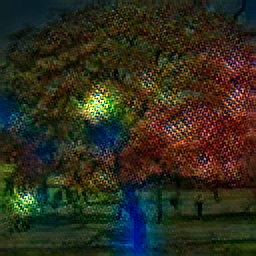

In [12]:
test()